## MCMC Testing on Intel Data - scrapped due to parameter limits issue.

In [28]:
import numpy as np
import pandas as pd
import scipy.optimize
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)
%matplotlib inline
%matplotlib widget

1.9.1


In [29]:
mcstat = MCMC()

In [30]:
dataframe = pd.read_csv('/Datasets/IntelData.csv')
newDF = dataframe[['Week','Forecasted Demand','Customer Orders']].copy(deep=True)
allForecasts = newDF.groupby('Week')['Forecasted Demand'].mean()
allCOs = newDF.groupby('Week')['Customer Orders'].mean()
newDF = allForecasts.to_frame(name='Forecasts')
newDF['COs'] = allCOs
newDF

,Forecasts,COs
Week,,
1,63641.381443,14143.072165
2,63660.948980,15053.602041
3,73899.152941,18662.976471
4,79106.714286,16715.964286
5,74011.863158,26580.926316
...,...,...
183,31936.617284,10061.413580
184,28333.934641,12077.431373
185,24904.424242,11460.230303


In [31]:
meanOfCOs = newDF['COs'].mean()
maxOfCOs = newDF['COs'].max()
print(meanOfCOs,maxOfCOs)

12861.281470100557 30597.555555555555


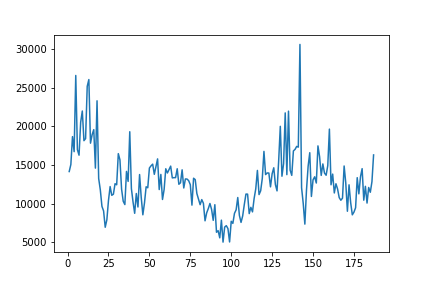

In [51]:
plt.close('all')
plt.plot(newDF['COs'])
plt.show()

In [33]:
ndp = 187
x = newDF.index.values
y = newDF['COs'].to_numpy()

In [34]:
print(x.shape)

(187,)


In [35]:
x = x.reshape(ndp, 1)
y = y.reshape(ndp, 1)

In [36]:
mcstat.data.add_data_set(x,y)

In [37]:
mcstat.data.n.append(len(newDF.index))
print(mcstat.data.n[0], y.shape)

187 (187, 1)


In [38]:
def modelFunction(x, theta):
    return theta[0]*x/(theta[1] + x) #Change accordingly

def ssfun(theta,data):
    res = data.ydata[0] - modelFunction(data.xdata[0], theta)
    return (res ** 2).sum(axis=0)

In [39]:
print(mcstat.data.ydata[0].shape)

(187, 1)


In [40]:
def residuals(p, x, y):
    # print(y,"Hello", modelFunction(x,p))
    return y - modelFunction(x, p)

theta0, ssmin = scipy.optimize.leastsq(residuals, x0 = [2,2], args=(mcstat.data.xdata[0].reshape(ndp,), mcstat.data.ydata[0].reshape(ndp,))) ## ISSUE STARTS HERE WITH x0 - the initial assumption
print(theta0, ssmin)
n = mcstat.data.n[0] # number of data points in model
p = len(theta0); # number of model parameters (dof)
ssmin = ssfun(theta0, mcstat.data) # calculate the sum-of-squares error
mse = ssmin/(n-p) # estimate for the error variance

[984.6824071  -15.60861007] 1


In [41]:
J = np.array([[x/(theta0[0]+x)], [-theta0[1]*x/(theta0[1]+x)**2]])
#, [-(2*theta0[2])/(x+theta0[2])**3]
J = J.transpose()
J = J.reshape(n,p)
tcov = np.linalg.inv(np.dot(J.transpose(), J))*mse
print('tcov = {}'.format(tcov))

tcov = [[ 9.64235139e+07 -1.44627546e+03]
 [-1.44627546e+03  5.43532525e+01]]


In [42]:
theta0[0]

984.6824070985119

In [43]:
theta0[1]

-15.60861007287535

In [44]:
mcstat.parameters.add_model_parameter(
    name='$\mu_{max}$',
    theta0=theta0[0],
    )
mcstat.parameters.add_model_parameter(
    name='$K_x$',
    theta0=theta0[1],
    )
# mcstat.parameters.add_model_parameter(
#     name='$K_x2$',
#     theta0=theta0[2],
#     )

In [45]:
mcstat.simulation_options.define_simulation_options(
    nsimu=5.0e3,
    updatesigma=1,
    qcov=tcov)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,
    sigma2=0.01**2)

In [46]:
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
$\mu_{max}$:    984.68 [     -inf,       inf] N( 0.00e+00,      inf)
     $K_x$:    -15.61 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 1.5 sec

In [47]:
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
mcstat.chainstats(chain, results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
$\mu_{max}$:  1.27e+04    839.20     68.08     31.66      0.93
     $K_x$:     -0.39      1.02      0.07     23.91  2.40e-03
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 2.30%
Stage 2: 15.74%
Net    : 18.04% -> 902/5000
---------------
Chain provided:
Net    : 18.04% -> 902/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


In [48]:
### Simulation does not run due to parameter limits
# Not sure what to change.
# EOF.

In [49]:
# A point estimate of the model parameters can be calculated from the
# mean of the |chain|. Here we plot the fitted model using the
# posterior means of the parameters.
xmod = np.linspace(1e-4,400)
plt.figure(1)
hmodel, = plt.plot(xmod,modelFunction(xmod,np.mean(chain, 0)),
                   '-k', label='model')
hdata, = plt.plot(mcstat.data.xdata[0], mcstat.data.ydata[0],
                  's', label='data');
plt.xlim([0, 400])
plt.xlabel('Weeks')
plt.ylabel('COs')
plt.legend(handles=[hdata, hmodel]);

Generating credible/prediction intervals:


Interval generation complete



Text(0.5, 1.0, 'Predictive envelopes of the model')

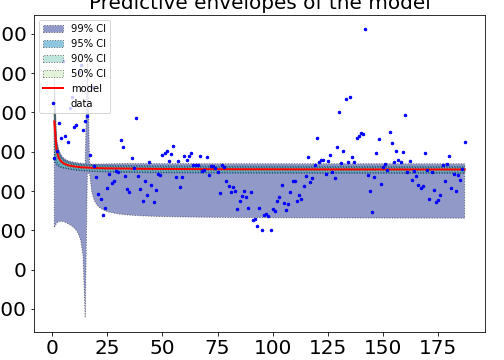

In [50]:
plt.close('all')
def predmodelFunction(data, theta):
    return modelFunction(data.xdata[0], theta)

mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=predmodelFunction)
mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=False)
# plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata=True)
plt.xlabel('Weeks', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('COs', fontsize=20)
plt.yticks(fontsize=20)
plt.title('Predictive envelopes of the model', fontsize=20)

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

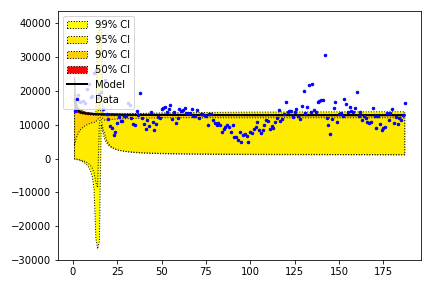

In [27]:
from pymcmcstat.propagation import calculate_intervals, plot_intervals

def newmodelFunction(q, data):
    # print(q)
    x = data.xdata[0]
    a, b = q
    return a*x/(b + x)

data = mcstat.data
intervals = calculate_intervals(chain, results, data, newmodelFunction,
                               s2chain=s2chain, nsample=500, waitbar=True)
f, ax = plot_intervals(intervals, data.xdata[0], data.ydata[0],
               addprediction=False, adddata=True, limits=[50, 90, 95, 99])
f.tight_layout()

## Running exact MCMC from https://nbviewer.org/github/prmiles/pymcmcstat_examples/blob/master/Monod.ipynb

In [ ]:
import numpy as np
import scipy.optimize
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)

In [ ]:
# Initialize MCMC object
mcstat = MCMC()
# Next, create a data structure for the observations and control
# variables. Typically one could make a structure |data| that
# contains fields |xdata| and |ydata|.
ndp = 7
x = np.array([28, 55, 83, 110, 138, 225, 375])  # (mg / L COD)
x = x.reshape(ndp, 1) # enforce column vector
y = np.array([0.053, 0.060, 0.112, 0.105, 0.099, 0.122, 0.125]) # (1 / h)
y = y.reshape(ndp, 1) # enforce column vector
# data structure 
mcstat.data.add_data_set(x,y)

In [ ]:
def modelFunction(x, theta):
    return theta[0]*x/(theta[1] + x)

def ssfun(theta,data):
    res = data.ydata[0] - modelFunction(data.xdata[0], theta)
    return (res ** 2).sum(axis=0)

In [ ]:
def residuals(p, x, y):
    return y - modelFunction(x, p)

theta0, ssmin = scipy.optimize.leastsq(
    residuals,
    x0=[0.15, 100],
    args=(mcstat.data.xdata[0].reshape(ndp,),
          mcstat.data.ydata[0].reshape(ndp,)))
n = mcstat.data.n[0] # number of data points in model
p = len(theta0); # number of model parameters (dof)
ssmin = ssfun(theta0, mcstat.data) # calculate the sum-of-squares error
mse = ssmin/(n-p) # estimate for the error variance

In [ ]:
J = np.array([[x/(theta0[1]+x)], [-theta0[0]*x/(theta0[1]+x)**2]])
J = J.transpose()
J = J.reshape(n,p)
tcov = np.linalg.inv(np.dot(J.transpose(), J))*mse
print('tcov = {}'.format(tcov))

In [ ]:
mcstat.parameters.add_model_parameter(
    name='$\mu_{max}$',
    theta0=theta0[0],
    minimum=0)
mcstat.parameters.add_model_parameter(
    name='$K_x$',
    theta0=theta0[1],
    minimum=0)

In [ ]:
mcstat.simulation_options.define_simulation_options(
    nsimu=5.0e3,
    updatesigma=1,
    qcov=tcov)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,
    sigma2=0.01**2)

In [ ]:
mcstat.run_simulation()

In [ ]:
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
mcstat.chainstats(chain, results)

In [ ]:
# A point estimate of the model parameters can be calculated from the
# mean of the |chain|. Here we plot the fitted model using the
# posterior means of the parameters.
xmod = np.linspace(1e-4,400)
plt.figure(1)
hmodel, = plt.plot(xmod,modelFunction(xmod,np.mean(chain, 0)),
                   '-k', label='model')
hdata, = plt.plot(mcstat.data.xdata[0], mcstat.data.ydata[0],
                  's', label='data');
plt.xlim([0, 400])
plt.xlabel('x (mg/L COD)')
plt.ylabel('y (1/h)')
plt.legend(handles=[hdata, hmodel]);

In [ ]:
from pymcmcstat import mcmcplot as mcp
# plot chain panel
mcp.plot_chain_panel(chain, names)
# The |'pairs'| options makes pairwise scatterplots of the columns of
# the |chain|.
pwfig = mcp.plot_pairwise_correlation_panel(
    chain, names, settings=dict(fig=dict(figsize=(4,4))))

In [ ]:
def predmodelFunction(data, theta):
    return modelFunction(data.xdata[0], theta)

mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelFunctionction=predmodelFunction)
mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=False)
# plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata=True)
plt.xlabel('x (mg/L COD)', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('y (1/h)', fontsize=20)
plt.yticks(fontsize=20)
plt.title('Predictive envelopes of the model', fontsize=20)

In [ ]:
from pymcmcstat.propagation import calculate_intervals, plot_intervals

def newmodelFunction(q, data):
    x = data.xdata[0]
    a, b = q
    return a*x/(b + x)

data = mcstat.data
intervals = calculate_intervals(chain, results, data, newmodelFunction,
                               s2chain=s2chain, nsample=500, waitbar=True)
f, ax = plot_intervals(intervals, data.xdata[0], data.ydata[0],
               addprediction=False, adddata=True, limits=[50, 90, 95, 99])
f.tight_layout()

## OK everything runs - proceed to fixing issue.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Normal distributed x and y vector with mean 0 and standard deviation 1
x = np.random.normal(0, 1, 500)
y = np.random.normal(0, 1, 500)
X = np.vstack((x, y)).T

plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated Data')
plt.axis('equal');

In [ ]:
newDF.to_clipboard(index=False)

In [ ]:
15 + 32 - 40